In [1]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os

Using TensorFlow backend.


In [2]:
# Set up data into train and test directories with folders of bobcat and not_bobcat
train_data_dir = './bobcat_cougar_data/train'#348 bobcat, 340 not_bobcat
test_data_dir = './bobcat_cougar_data/test'#348 bobcat, 340 not_bobcat

test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=132)

train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=340)

# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 685 images belonging to 2 classes.
Found 680 images belonging to 2 classes.


/anaconda3/lib/python3.7/site-packages/PIL/Image.py:968: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


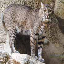

In [11]:
array_to_img(train_images[130])

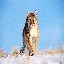

In [12]:
array_to_img(train_images[101])

In [13]:
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(340, 64, 64, 3)
(340, 2)
(132, 64, 64, 3)
(132, 2)


In [15]:
train_img_unrow = train_images.reshape(340, -1).T
test_img_unrow = test_images.reshape(132, -1).T

In [16]:
np.shape(train_img_unrow)
np.shape(test_img_unrow)

(12288, 132)

In [17]:
train_generator.class_indices
test_generator.class_indices

{'bobcat': 0, 'not_bobcat': 1}

In [18]:
train_labels_final = train_labels.T[[1]]
test_labels_final = test_labels.T[[1]]

In [19]:
np.shape(train_labels_final)
np.shape(test_labels_final)

(1, 132)

In [20]:
train_img_final = train_img_unrow/255
test_img_final = test_img_unrow/255

In [21]:
b = 0

In [22]:
def init_w(n):
    w = np.zeros((n,1))
    return w

In [23]:
w = init_w(64*64*3)

In [24]:
def propagation(w, b, x, y):
    l = x.shape[1]
    y_hat = 1/(1 + np.exp(- (np.dot(w.T,x)+b)))                                  
    cost = -(1/l) * np.sum(y * np.log(y_hat)+(1-y)* np.log(1-y_hat))    
    dw = (1/l) * np.dot(x,(y_hat-y).T)
    db = (1/l) * np.sum(y_hat-y)
    return dw, db, cost

In [25]:
dw, db, cost = propagation(w, b, train_img_final, train_labels_final)

In [26]:
print(dw)

print(db)

print(cost)

[[0.02380046]
 [0.02380046]
 [0.01912341]
 ...
 [0.02866205]
 [0.0283391 ]
 [0.02122261]]
0.029411764705882353
0.6931471805599453


In [27]:
def optimization(w, b, x, y, num_iterations, learning_rate, print_cost = False):
    
    costs = []
    
    for i in range(num_iterations):
        dw, db, cost = propagation(w, b, x, y)    
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        # Record the costs and print them every 50 iterations
        if i % 50 == 0:
            costs.append(cost)
        if print_cost and i % 50 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    return w, b, costs

In [28]:
w, b, costs = optimization(w, b, train_img_final, train_labels_final, num_iterations= 151, learning_rate = 0.0001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 50: 0.686800
Cost after iteration 100: 0.684189
Cost after iteration 150: 0.681631


In [29]:
def prediction(w, b, x):
    l = x.shape[1]
    y_prediction = np.zeros((1,l))
    w = w.reshape(x.shape[0], 1)
    y_hat = 1/(1 + np.exp(- (np.dot(w.T,x)+b))) 
    p = y_hat
    
    for i in range(y_hat.shape[1]):
        if (y_hat[0,i] > 0.5): 
            y_prediction[0,i] = 1
        else:
            y_prediction[0,i] = 0
    return y_prediction

In [30]:
w = np.array([[0.035],[0.123],[0.217]])
b = 0.2
x = np.array([[0.2,0.4,-1.2,-2],[1,-2.,0.1,-1],[0.2,0.4,-1.2,-2]])

prediction(w,b,x)

array([[1., 1., 0., 0.]])

In [31]:
def model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):

    b = 0
    w = init_w(np.shape(x_train)[0]) 

    # Gradient descent (≈ 1 line of code)
    w, b, costs = optimization(w, b, x_train, y_train, num_iterations, learning_rate, print_cost)
    
    y_pred_test = prediction(w, b, x_test)
    y_pred_train = prediction(w, b, x_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    output = {"costs": costs,
         "y_pred_test": y_pred_test, 
         "y_pred_train" : y_pred_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return output

In [32]:
output = model(train_img_final, train_labels_final, test_img_final, test_img_final, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 50: 1.048242
Cost after iteration 100: 0.955298
Cost after iteration 150: 0.871780
Cost after iteration 200: 0.790038
Cost after iteration 250: 0.709229
Cost after iteration 300: 0.629567
Cost after iteration 350: 0.551539
Cost after iteration 400: 0.475914
Cost after iteration 450: 0.404240
Cost after iteration 500: 0.339841
Cost after iteration 550: 0.290412
Cost after iteration 600: 0.266709
Cost after iteration 650: 0.255561
Cost after iteration 700: 0.245836
Cost after iteration 750: 0.236851
Cost after iteration 800: 0.228505
Cost after iteration 850: 0.220718
Cost after iteration 900: 0.213431
Cost after iteration 950: 0.206592
Cost after iteration 1000: 0.200160
Cost after iteration 1050: 0.194097
Cost after iteration 1100: 0.188372
Cost after iteration 1150: 0.182958
Cost after iteration 1200: 0.177829
Cost after iteration 1250: 0.172965
Cost after iteration 1300: 0.168344
Cost after iteration 1350: 0.163949
Cost after iter